INFO:tensorflow:Restoring parameters from ./SESSIONS_STORED/DNN_Model_Initialized-0


AVERAGE COST = 23434.82245
NEURON: W0 [0][0] | VALUE = 0.06065585
NEURON: W0 [1][0] | VALUE = 1.0561682
NEURON: W0 [2][0] | VALUE = -0.06969048
NEURON: B0 [0] | VALUE = [0.5460733]


AVERAGE COST = 20760.051000000014
NEURON: W0 [0][0] | VALUE = -0.38593954
NEURON: W0 [1][0] | VALUE = 1.8022879
NEURON: W0 [2][0] | VALUE = -0.84713656
NEURON: B0 [0] | VALUE = [0.82857555]


AVERAGE COST = 18038.012990624993
NEURON: W0 [0][0] | VALUE = -0.5297255
NEURON: W0 [1][0] | VALUE = 2.539751
NEURON: W0 [2][0] | VALUE = -1.6255296
NEURON: B0 [0] | VALUE = [1.0917821]


AVERAGE COST = 15458.50723124999
NEURON: W0 [0][0] | VALUE = -0.45220757
NEURON: W0 [1][0] | VALUE = 3.2539465
NEURON: W0 [2][0] | VALUE = -2.4047616
NEURON: B0 [0] | VALUE = [1.4218496]


FINAL COST FOR THE MODEL PROVIDED = 280290.2


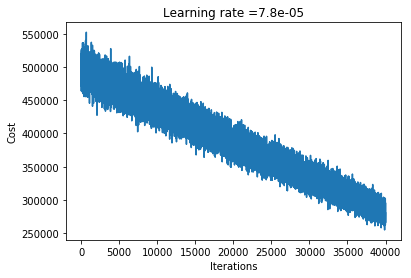

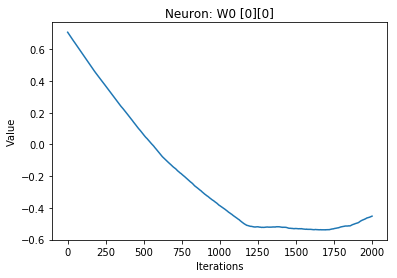

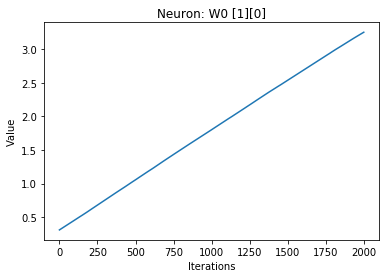

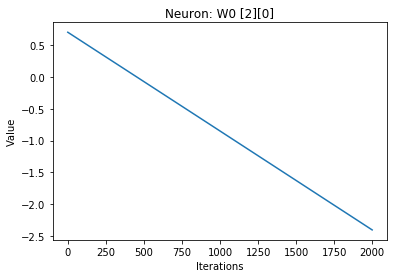

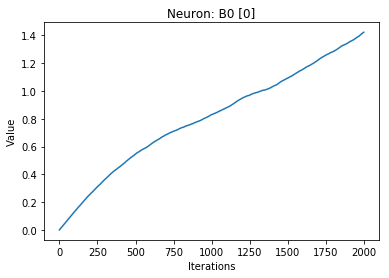

INFO:tensorflow:Restoring parameters from ./SESSIONS_STORED/DNN_Model_Trained-0


TOTAL ACCURACY = 17.3 %


In [12]:
## OUTPUT (y_size) HAS TO BE = 1 FOR THIS ALGORITHM

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from inspect import signature


class DNN_Model:
    def __init__(self, x_size, y_size = 1):
        """
        The initialization for this function takes the input and output sizes
        
        **********************************************************************
        NOTE:
         - Output size must be equal 1, as the cost function is already defined
        **********************************************************************
        """
        
        np.random.seed(1)
        
        self.x_size = x_size
        
        assert y_size == 1, "OUTPUT (y_size) SHOULD BE 1 FOR THIS MODEL"
        self.y_size = y_size
        
        self.X = None
        self.Y = None
        self.W_list = None
        self.B_list = None
        self.sizes_array = None
        
        #KEEPS TRACK OF AT LEAST A FIRST INITIALIZATION
        self.model_initialized = False
        
        #DEFINED ON INITIALIZE MODEL
        self.training_cost = None
        
        #WE STORE THE PATH TO THE LAST SESSION SAVED (values for all variables)
        self.last_session = None

    def _get_placeholders(self, x_size,y_size):
        """
        This function creates and returns the main INPUT & OUTPUT PLACEHOLDERS
        
        **********************************************************************
        NOTE:
         - It does not automatically assign the values to internal variables
        **********************************************************************
        """
        
        X = tf.placeholder(tf.float32, name="X", shape=(None,x_size))
        Y = tf.placeholder(tf.float32, name="Y", shape=(None,y_size))

        return X,Y



    def create_training_examples(self, function, samples = 1000):
        """
        This function creates and returns the TRAINING EXAMPLES
        
        INPUTS:
            - FUNCTION: This function receives a vector with the inputs, and
            returns the desired output. It defines the relation that the DNN
            is about to learn
            
            - SAMPLES: Number of training samples desired
        
        OUTPUTS:
            - X_TRAIN
            - Y_TRAIN
        
        **********************************************************************
        NOTE:
         - It does not automatically assign the values to internal variables
        **********************************************************************
        """
        
        x_size, y_size = self.x_size, self.y_size
        
        X_train = []
        direct_order = True

        
        mult_array = [1-x/20 for x in range(10)]
        mult_array += [-x for x in mult_array]
        offset_array = [x - samples/2 for x in range(int(samples/10))]

        for i in range(x_size):

            if direct_order:
                X_train.append([random.choice(mult_array)*R + random.choice(offset_array) for R in range(samples)])
            else:
                X_train.append([random.choice(mult_array)*R + random.choice(offset_array) for R in range(samples,0,-1)])

            #We invert the values to give more randomness to the relation between variables for each case
            direct_order = not direct_order


        X_train = np.reshape(X_train,(x_size,samples))
        X_train = np.reshape(X_train,(samples,x_size),1)
        
        Y_train = []
        for i in range(samples):
            Y_train.append(function(X_train[i]))
        
        Y_train = np.reshape(Y_train,(samples,y_size))

        return X_train, Y_train



    def _create_layer(self, prev_layer, n_prev, n_post, layer = "", ReLU = True):
        """
        This function creates a new layer based on the previous and following
        layers sizes. It also connects this new layer to the previous one
        
        *An additional RELU parameter allows to include that Activation to
        the layer or not
        
        INPUTS:
            - PREV_LAYER: The previous layer to which connect this new layer
            - N_PREV: The size of the PREVIOUS layer
            - N_POST: The size of the FOLLOWING layer
            - LAYER: The number to be given to THIS NEW layer
            - RELU: True --> INCLUDE RELU Activation || False --> DO NOT
        
        OUTPUTS:
            - A: Final TENSOR from previous layer
            - W: WEIGHTS (variables) for this new layer
            - B: BIASES (variables) for this new layer
        
        **********************************************************************
        NOTE:
         - It does not automatically assign the values to internal variables
        **********************************************************************
        """
        
        W = tf.Variable(tf.random_uniform([n_prev,n_post]), name="W_L"+str(layer), dtype = tf.float32)
        B = tf.Variable(tf.zeros([1,n_post]), name="B_L"+str(layer), dtype = tf.float32)
        Z = np.sum((tf.matmul(prev_layer,W),B),axis = 0)
        
        if ReLU:
            A = tf.nn.relu(Z)
        else:
            A = Z
        
        #print("Prev Layer - Shape:", np.shape(prev_layer))
        #print("Created W",layer," - Shape:", np.shape(W))
        #print("Created B",layer," - Shape:", np.shape(B))
        
        return A,W,B



    def _create_network(self):
        """
        This function creates the whole network layer by layer. It calls
        self.create_layer with the pertinent values.
        
        *For now, it assumes the final layer might require negative values.
        Therefore, NO ACTIVATION function is included BEFORE the OUTPUT
        
        INPUTS:
            - SIZES_ARRAY: The number of elements per layer from left to right
                * It includes the INPUT and OUTPUT sizes as well
        
        **********************************************************************
        NOTE:
         - It stores the values as internal variables
        **********************************************************************
        """
        
        sizes_array = self.sizes_array
        
        n = len(sizes_array)
        assert n >= 2, "2 sizes must be given at least: [input_size, (layer_size,) output_size]"

        X,Y = self._get_placeholders(sizes_array[0], sizes_array[n-1])

        W_list = []
        B_list = []
        A = X
        for i in range(1, n-1):
            A,W,B = self._create_layer(A, sizes_array[i-1], sizes_array[i], layer = i, ReLU = True)
            W_list.append(W)
            B_list.append(B)

        i = n-1
        A,W,B = self._create_layer(A, sizes_array[i-1], sizes_array[i], layer = i, ReLU = False)
        W_list.append(W)
        B_list.append(B)

        self.X = X
        self.Y = Y
        self.Z = A
        self.W_list = W_list
        self.B_list = B_list
        
        return



    def save_session(self, sess, name, identifier = 0):
        """
        This function SAVES the VALUES of the VARIABLES from the session
        passed.
        
        INPUTS:
            - SESS: The current session
            
            - NAME: The name for the saved session
            
            - IDENTIFIER: A number to identify the session
        
        **********************************************************************
        NOTE:
         - It saves the session on the folder where this function is found.
         Inside a folder called: SESSIONS_STORED
        **********************************************************************
        """
        
        #variables_to_save = []
        #
        #for elem in self.W_list:
        #    variables_to_save.append(elem)
        #
        #for elem in self.B_list:
        #    variables_to_save.append(elem)
        #
        #saver = tf.train.Saver(variables_to_save)

        saver = tf.train.Saver()
                                    ## File name: "name"-"identifier"
        path = saver.save(sess, './SESSIONS_STORED/DNN_Model_'+name, global_step=identifier)
        
        ## WE CREATE AN INTERNAL BACKUP
        self.last_session = path
        
        return path



    def restore_session(self, sess, path):
        """
        This function RESTORES the VALUES of the VARIABLES STORED on the PATH
        passed. It sets those values inside the SESSION passed.
        
        INPUTS:
            - SESS: The current session where the values will be updated
            
            - PATH: The location where the session saved is located
        """
        
        #variables_to_save = []
        #
        #for elem in self.W_list:
        #    variables_to_save.append(elem)
        #
        #for elem in self.B_list:
        #    variables_to_save.append(elem)
        #
        #saver = tf.train.Saver(variables_to_save)

        saver = tf.train.Saver()
        saver.restore(sess, path)
        
        return



    def create_model(self, middle_layers = None, x_size = None, y_size = None):
        """
        This function creates the main model based on the inputs provided.
        New values for x_size and y_size can be provided.
        
        INPUTS:
            - SESS: The current session where the values will be updated
            
            - PATH: The location where the session saved is located
        """
        
        if x_size == None:
            x_size = self.x_size
        else:
            self.x_size = x_size
        
        if y_size == None:
            y_size = self.y_size
        else:
            assert y_size == 1, "Y SIZE has to be equal 1 for this model"
            self.y_size = y_size
        
        sizes_array = [x_size, y_size]
        
        if middle_layers:
            for layer in middle_layers:
                n = len(sizes_array)
                sizes_array.insert(n-1, layer)
        
        self.sizes_array = sizes_array
        
        
        
        ## CREATES AND RELATES PLACEHOLDERS, WEIGHTS, AND BIASES
        self._create_network()

        return



    def initialize_model(self, learning_rate):
        """
        This function initializes the main model based on the variables previously
        provided.
        """
        
        assert self.W_list != None and self.B_list != None, "THE MODEL HAS TO BE CREATED PRIOR TO BEING INITIALIZED [ self.CREATE_MODEL() ]"
            
        with tf.Session() as sess:
            
            ## DEFINES TRAINING CONDITIONS
            ### It needs to be inserted before initializing
            Y, Z = self.Y, self.Z
            cross_entropy = tf.reduce_mean(tf.reduce_sum(abs(Y-Z)))
            train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
            
            ## SAVES TRAINING CONDITIONS
            self.training_cost = [cross_entropy, train_step]
            
            ## INITIALIZES VARIABLES
            init = tf.global_variables_initializer()
            sess.run(init)

            ## SAVES SESSION
            saved_session = self.save_session(sess,"Initialized",0)
            
            self.model_initialized = True
            
            #return saved_session
            return

        return None



    def train_model(self, X_train, Y_train, training_steps = 40000, learning_rate = 0.000078, batch_size = 20, plot_cost = True, print_variables = [20,None]):
        """
        This function trains the main model based on the previous data provided.
        New values for x_size and y_size can be provided.
        
        INPUTS:
            - SAVED_SESSION: The PATH to the session with the values to be used
            
            - X_TRAIN: The input training set
            
            - Y_TRAIN: The output training set
            
            - TRAINING_STEPS: # of times to RUN the COST FUNCTION over the
            current model
            
            - LEARNING_RATE: Learning rate for the Adam optimizer
            
            - BATCH_SIZE
            
            - PLOT_COST
            
            - PRINT_VARIABLES
        
        OUTPUTS:
            - SAVED_SESSION: The PATH to the SAVED session
        
        **********************************************************************
        NOTE:
         - SELF.CREATE_MODEL has to be CALLED FIRST (prior to this func)
        **********************************************************************
        """
        
        ## WE RETRIEVE THE INPUT AND OUTPUT TENSORS
        X = self.X
        Y = self.Y
        Z = self.Z
        W_list = self.W_list
        B_list = self.B_list
        
        #WE INITIALIZED THE MODEL (a new or existing one)
        if not self.model_initialized:
            saved_session = self.initialize_model(learning_rate)
        
        saved_session = self.last_session

        with tf.Session() as sess:
            
            ## WE RESTORE THE VARIABLES STORED
            ### We do a previous initialization to make sure ADAMs variables are initialized
            self.restore_session(sess,saved_session)

            ## RETRIEVES TRAINING CONDITIONS
            cross_entropy, train_step = self.training_cost
            
            ## WE INITIALIZE THE TRACKING OF BOTH VARIABLES AND COST
            average_cost = 0
            cost_list = []

            if print_variables != None:
                assert len(print_variables) == 2, "2 PARAMETERS MUST BE PASSED ON 'print_variables': 1st - # of training steps to take a record | 2nd # of records to plot values"
                n = print_variables[0]

                if print_variables[1]:
                    n_2 = print_variables[1]
                else:
                    n_2 = int(training_steps/n)

                if n < 1:
                    n = 1
                if n_2 < 1:
                    n_2 = 1

                W_dict = {}
                B_dict = {}


            ## WE START THE TRAINING LOOP
            for i in range(training_steps):

                ## WE RETRIEVE A RANDOM BATCH AND WE RUN IT
                i_batch = random.sample(range(np.shape(X_train)[0]),batch_size)
                a = sess.run([train_step,cross_entropy], feed_dict={X: X_train[i_batch,:], Y: Y_train[i_batch]})

                ## WE SAVE THE CURRENT COST IF REQUESTED
                if plot_cost:
                    cost_list.append(a[1])

                if print_variables != None:
                    ## WE PRINT BOTH COST AND VARIABLES VALUES IF REQUESTED
                    if i%(n*n_2) == 0 and i != 0:
                        average_cost += a[1]/(n*n_2)
                        print("\n")
                        print("AVERAGE COST =",average_cost)
                        average_cost = 0

                        self.print_all_variables(0)
                        self.print_all_variables(1)

                    ## WE SAVE THE VARIABLES VALUES IF REQUESTED
                    if i%n == 0 and i != 0:
                        average_cost += a[1]/(n*n_2)
                        W_dict,_ = self.save_all_variables(0, W_dict)
                        B_dict,_ = self.save_all_variables(1, B_dict)


            ## WE PRINT THE FINAL COST OF THE MODEL
            print("\n\nFINAL COST FOR THE MODEL PROVIDED =",a[1])


            ## WE PRINT THE EVOLUTION OF COST FROM THE MODEL
            fig = 0
            if plot_cost:
                self.plot_image(fig, cost_list, 100, y_label = "Cost", title = "Learning rate =" + str(learning_rate))
                fig += 1

            ## WE PRINT THE EVOLUTION OF EACH VARIABLE OF THE MODEL
            if print_variables != None:
                for neuron in W_dict.keys():
                    self.plot_image(fig, W_dict[neuron], 100, y_label = "Value", title = "Neuron: " + neuron)
                    fig += 1
                for neuron in B_dict.keys():
                    self.plot_image(fig, B_dict[neuron], 100, y_label = "Value", title = "Neuron: " + neuron)
                    fig += 1

            ## WE SAVE THE SESSION
            saved_session = self.save_session(sess,"Trained",0)

            #return saved_session
            return

        return None



    def test_model(self, X_test, Y_test):
        """
        This function tests the main model based on the previous data provided.
        New values for x_size and y_size can be provided.
        
        INPUTS:
            - SAVED_SESSION: The PATH to the session with the values to be used
            
            - X_TEST: The input training set
            
            - Y_TEST: The output training set
        
        OUTPUTS:
            - TOTAL_ACCURACY: The ACCURACY that has been tested
        
        **********************************************************************
        NOTE:
         - SELF.CREATE_MODEL has to be CALLED FIRST (prior to this func)
         - SELF.TRAIN_MODEL should also be called first...
        **********************************************************************
        """
        
        saved_session = self.last_session
        
        assert self.model_initialized == True, "Model has to be created and initialized prior to be tested"
        
        X = self.X
        Y = self.Y
        Z = self.Z

        with tf.Session() as sess:
            
            ## WE RESTORE THE GIVEN VERSION
            self.restore_session(sess,saved_session)

            ## WE DEFINE THE TESTING FUNCTION
            #correct_prediction = tf.equal(tf.argmax(Z,1),tf.argmax(Y,1))
            a_val = tf.abs((Y-Z)/tf.maximum(Z,Y))
            accuracy = tf.reduce_mean(tf.cast(a_val,tf.float32), name = 'Accuracy')

            ## WE TEST THE MODEL
            a = sess.run([accuracy], feed_dict={X:X_test, Y:Y_test})
            
            ## WE CALCULATE THE ACCURACY
            total_accuracy = (1/(1+2*a[0]))*100
            ## WE MAKE IT GIVE ONE DECIMAL POINT
            total_accuracy = int(total_accuracy*10)/10
            
            ## WE PRINT THE TOTAL ACCURACY
            print("\n\nTOTAL ACCURACY =",total_accuracy,"%")

            return total_accuracy

        return None
    
    
    
    def print_all_variables(self, Var_Num = 0):
        """
        This function is used to print the current values. It is used for
        debugging purporses in case the user wants to have access to certain
        variables throughout runtime.
        
        INPUTS:
            - VAR_NUM: It is used to select between WEIGHTS and BIASES
                * 0 = print WEIGHTS || 1 = print BIASES
        
        OUTPUTS:
            - VALUES_DICT: Returns the values stored for manipulation purposes
        
        **********************************************************************
        NOTE:
         - It prints the values chosen (weights or biases)
        **********************************************************************
        """
        
        if Var_Num == 0:
            MainList = self.W_list
            MainName = "W"
        elif Var_Num == 1:
            MainList = self.B_list
            MainName = "B"
        else:
            assert 1 == 0, "Var_Num has to be equal '0' or '1'"
        
        
        values_dict = {}
        sizes_array = self.sizes_array

        n = len(sizes_array)
        assert n >= 2, "2 sizes must be given at least: [input_size, (layer_size,) output_size]"

        if Var_Num == 0:
            for elem in range(n-1):
                for i in range(sizes_array[elem]):
                    for j in range(sizes_array[elem+1]):
                        neuron = MainName + str(elem) + " [" + str(i) + "][" + str(j) + "]"
                        values_dict[neuron] = MainList[elem].eval()[i][j]
                        print("NEURON:", neuron, "| VALUE =",values_dict[neuron])

        elif Var_Num == 1:
            for elem in range(n-1):
                for i in range(sizes_array[elem+1]):
                    neuron = MainName + str(elem) + " [" + str(i) + "]"
                    values_dict[neuron] = MainList[elem].eval()[i]
                    print("NEURON:", neuron, "| VALUE =",values_dict[neuron])

        return values_dict



    def save_all_variables(self, Var_Num = 0, values_dict = {}):
        """
        This function is used to keep record of current values. It is used for
        PLOTTING purporses.
        
        INPUTS:
            - VAR_NUM: It is used to select between WEIGHTS and BIASES
                * 0 = print WEIGHTS || 1 = print BIASES
            
            - VALUES_DICT: Receives a dictionary with previous values to which
            incorporate the ones to be saved right now (optional)
        
        OUTPUTS:
            - VALUES_DICT: Returns the values stored for manipulation purposes
        
        **********************************************************************
        NOTE:
         - It prints the values chosen (weights or biases)
        **********************************************************************
        """
        
        if Var_Num == 0:
            MainList = self.W_list
            MainName = "W"
        elif Var_Num == 1:
            MainList = self.B_list
            MainName = "B"
        else:
            assert 1 == 0, "Var_Num has to be equal '0' or '1'"
        
        
        sizes_array = self.sizes_array

        n = len(sizes_array)
        assert n >= 2, "2 sizes must be given at least: [input_size, (layer_size,) output_size]"
        
        
        if Var_Num == 0:
            for elem in range(n-1):
                for i in range(sizes_array[elem]):
                    for j in range(sizes_array[elem+1]):
                        neuron = MainName + str(elem) + " [" + str(i) + "][" + str(j) + "]"
                        if neuron in values_dict.keys():
                            values_dict[neuron].append(MainList[elem].eval()[i][j])
                        else:
                            values_dict[neuron] = [MainList[elem].eval()[i][j]]
        
        elif Var_Num == 1:
            for elem in range(n-1):
                for i in range(sizes_array[elem+1]):
                    neuron = MainName + str(elem) + " [" + str(i) + "]"
                    if neuron in values_dict.keys():
                        values_dict[neuron].append(MainList[elem].eval()[i])
                    else:
                        values_dict[neuron] = [MainList[elem].eval()[i]]
        
        
        return values_dict, neuron




    def plot_image(self, n, obj, percentage_shown, y_label = "", title = None):
        """
        This function PLOTS the values passed
        
        INPUTS:
            - N: The figure number that this plot should have
            
            - OBJ: The values to be plotted
            
            - PERCENTAGE_SHOWN: What extent from the whole records should be
            displayed, starting from the end.
                * F.i.: 10 will shown the last 10% of the whole array
            
            - Y_LABEL: The label to be displayed on the FIGURE
            
            - TITLE: The title to be displayed on the FIGURE
        """
        
        training_steps = len(obj)
        
        plt.figure(n)
        aux_i = training_steps - int(training_steps*(percentage_shown/100))
        plt.plot(np.squeeze(obj[aux_i:training_steps]))
        plt.ylabel(y_label)
        plt.xlabel("Iterations")
        if title:
            plt.title(title)
        plt.show()

        return





if __name__ == "__main__":
    
    ##***********************************
    ## INITIALIZATION
    ##***********************************
    x_size = 3
    y_size = 1
    middle_layers = [] #[2] #None (if only 1 layer)
    
    ## WE INITIALIZE THE MODEL
    new_model = DNN_Model(x_size,y_size)
    saved_session = new_model.create_model(middle_layers)
    
    
    ##***********************************
    ## TRAINING
    ##***********************************
    training_steps = 40001
    learning_rate = 0.000078
    batch_size = 256
    print_variables = [20,500]
    
    
    ## WE CREATE THE TRAINING SAMPLES
    function = lambda INPUT: 2*INPUT[0] + 5*INPUT[1] - 7*INPUT[2]
    samples = 500
    assert samples >= batch_size, "# of SAMPLES (training batch) has to be greater or equal than the BATCH SIZE"
    X_train, Y_train = new_model.create_training_examples(function, samples)
    
    
    ## TRAIN MODEL
    new_model.train_model(X_train, Y_train, training_steps, learning_rate, batch_size, print_variables = print_variables)
    
    
    ##***********************************
    ## CREATE TESTING SAMPLES
    ##***********************************
    samples = 200
    X_test, Y_test = new_model.create_training_examples(function, samples)
    
    
    ## TEST MODEL
    accuracy = new_model.test_model(X_test, Y_test)
    
    
    
    

INFO:tensorflow:Restoring parameters from ./SESSIONS_STORED/DNN_Model_Trained-0


AVERAGE COST = 12859.818757812509
NEURON: W0 [0][0] | VALUE = -0.2283692
NEURON: W0 [1][0] | VALUE = 3.9099112
NEURON: W0 [2][0] | VALUE = -3.1850638
NEURON: B0 [0] | VALUE = [1.8881482]


AVERAGE COST = 10464.838215625
NEURON: W0 [0][0] | VALUE = 0.095358
NEURON: W0 [1][0] | VALUE = 4.377479
NEURON: W0 [2][0] | VALUE = -3.964449
NEURON: B0 [0] | VALUE = [2.5173812]


AVERAGE COST = 8057.368157812494
NEURON: W0 [0][0] | VALUE = 0.53825206
NEURON: W0 [1][0] | VALUE = 4.643414
NEURON: W0 [2][0] | VALUE = -4.743154
NEURON: B0 [0] | VALUE = [3.1482882]


AVERAGE COST = 5690.119107812501
NEURON: W0 [0][0] | VALUE = 1.036766
NEURON: W0 [1][0] | VALUE = 4.785204
NEURON: W0 [2][0] | VALUE = -5.5219874
NEURON: B0 [0] | VALUE = [3.7903714]


AVERAGE COST = 3306.2425632812506
NEURON: W0 [0][0] | VALUE = 1.5415612
NEURON: W0 [1][0] | VALUE = 4.9067454
NEURON: W0 [2][0] | VALUE = -6.3010516
NEURON: B0 [0] | VALUE = [4

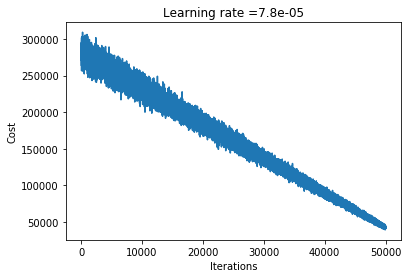

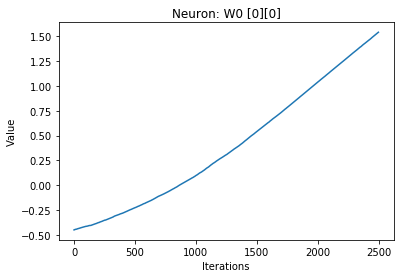

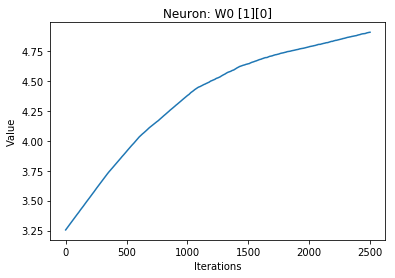

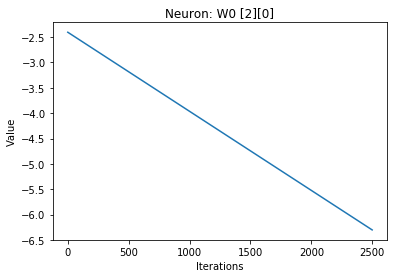

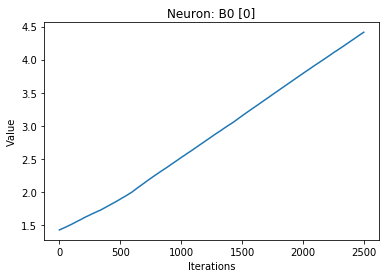

INFO:tensorflow:Restoring parameters from ./SESSIONS_STORED/DNN_Model_Trained-0


TOTAL ACCURACY = 68.4 %


In [13]:
# We end with 17.3% accuracy after 50001 steps

## EXTRA TRAINING
training_steps = 50001
new_model.train_model(X_train, Y_train, training_steps, learning_rate, batch_size, print_variables = print_variables)


## TESTING
accuracy = new_model.test_model(X_test, Y_test)
  

INFO:tensorflow:Restoring parameters from ./SESSIONS_STORED/DNN_Model_Trained-0


AVERAGE COST = 948.8512829925542
NEURON: W0 [0][0] | VALUE = 2.006471
NEURON: W0 [1][0] | VALUE = 5.006327
NEURON: W0 [2][0] | VALUE = -6.997315
NEURON: B0 [0] | VALUE = [4.6332116]


AVERAGE COST = 22.355655737304673
NEURON: W0 [0][0] | VALUE = 2.0050719
NEURON: W0 [1][0] | VALUE = 5.0050516
NEURON: W0 [2][0] | VALUE = -6.997541
NEURON: B0 [0] | VALUE = [3.8428767]


AVERAGE COST = 18.280539660644532
NEURON: W0 [0][0] | VALUE = 2.0041735
NEURON: W0 [1][0] | VALUE = 5.0041847
NEURON: W0 [2][0] | VALUE = -6.998088
NEURON: B0 [0] | VALUE = [3.0676854]


AVERAGE COST = 14.17892442626953
NEURON: W0 [0][0] | VALUE = 2.0029757
NEURON: W0 [1][0] | VALUE = 5.0030303
NEURON: W0 [2][0] | VALUE = -6.998713
NEURON: B0 [0] | VALUE = [2.2929718]


AVERAGE COST = 10.078278277587895
NEURON: W0 [0][0] | VALUE = 2.0019255
NEURON: W0 [1][0] | VALUE = 5.0020843
NEURON: W0 [2][0] | VALUE = -6.9991612
NEURON: B0 [0] | VALUE = 

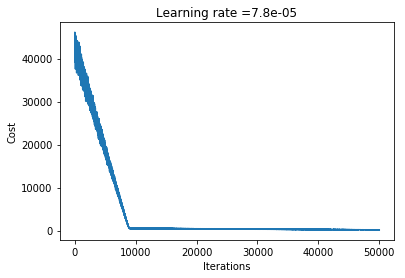

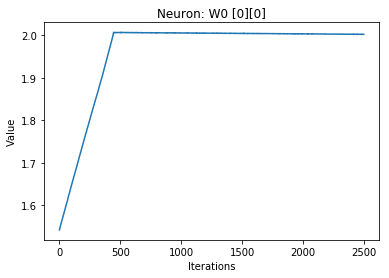

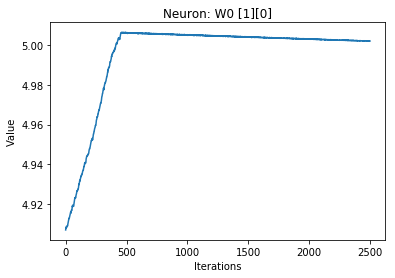

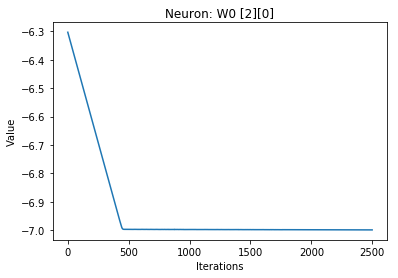

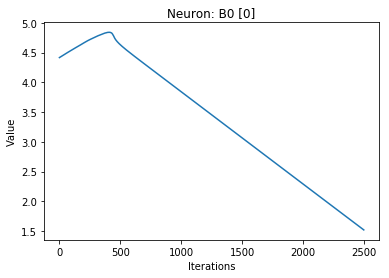

INFO:tensorflow:Restoring parameters from ./SESSIONS_STORED/DNN_Model_Trained-0


TOTAL ACCURACY = 96.5 %


In [14]:
# After another 50001 steps, we reach 68.4% ACCURACY
# Values are almost reaching the KNOWN REAL VALUES from the function given: W0[0] = 2 | W0[1] = 5 | W0[0] = -7

## EXTRA TRAINING
training_steps = 50001
new_model.train_model(X_train, Y_train, training_steps, learning_rate, batch_size, print_variables = print_variables)


## TESTING
accuracy = new_model.test_model(X_test, Y_test)

In [ ]:
# After another 50001 steps, we reach 96.5% ACCURACY
# Values are finally reaching the KNOWN VALUES: W0[0] = 2 | W0[1] = 5 | W0[0] = -7
# BETA IS GOING TOWARDS 0, which is the case as well: B0[0] = 0
